<a href="https://colab.research.google.com/github/yavorkovachev/Reinforcement_learning/blob/main/Reinforce/Reinforce_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REINFORCE algorithm

## 1. Algorithm and environment overview 

This notebook shows how to apply the REINFORCE algoritm to solve OpenAI Gym's [CartPole-v0](https://github.com/openai/gym/wiki/CartPole-v0) control problem.

### 1.1 Overview

We use a neural network to apporixmate the optimal policy function (instead of keeping a table of value function estimates as in [Q-learning](https://en.wikipedia.org/wiki/Q-learning)) and apply gradient ascent to find the optimal weights of the network i.e. the weights which maximize expected future returns. The neural network takes the current state as input and outputs a discrete probability distribution over the action set.

If we let $\theta$ denote the weights of the neural network and $U(\theta)$ the expected future rewards.  We want to solve the problem 

$$max_{\theta} U(\theta) = max_\theta E_{\pi_{\theta}}[R(\tau)]$$

where the expectation is taken over all possible state-action sequences, also called trajectories, of (horizon) lenght H $\tau = (s_{0}, a_{0},...,s_{H}, a_{H},s_{H+1})$, and $\pi_{\theta}$ is the policy function determined by $\theta$ while $R(\cdot)$ is the reward function.


### 1.2 The REINFORCE algorithm 

The REINFORCE algorithm solves the optimization problem above in the following steps: 

1. Use policy $\pi_\theta$ determined by the weights of the neural network to generate $m$ trajectories $\{\tau^{(1)}, \tau^{(2)},..., \tau^{(m)} \}$ with (horizon) length $H$ where the i-th trajectory is defined as the collection of state action pairs

$$ \tau^{(i)} = (s_{0}^{(i)}, a_{0}^{(i)},...,s_{H}^{(i)}, a_{H}^{(i)},s_{H+1}^{(i)}) $$


2. Use the trajectories to estimate the gradient $\hat{g} = \triangledown{_\theta} E_{\pi_{\theta}}[R(\tau)] $ 


\begin{equation}
\hat{g} =  \triangledown_{\theta} E_{\pi_{\theta}}[R(\tau)] :=  \frac{1}{m} \sum_{i=1}^{m} \sum_{t=0}^{H} \triangledown{_\theta} \text{log}_{\pi_{\theta}}(a_{t}^{(i)}|s_{t}^{(i)})R(\tau^{(i)}) \tag{1}
\end{equation}

3. Update the weights of the policy: 
$$ \theta \leftarrow \theta + \alpha \hat{g} $$

4. Loop over steps 1-3

### 1.3 The REINFORCE gradient approximation

The crucial ingredient in the REINFORCE algorithm is the approximation formula in eq. (1). The derivation is shown below:

\begin{align*}
\triangledown{_\theta} E_{\pi_{\theta}}[R(\tau)] 
&= \triangledown{_\theta} \sum_{\tau} P(\tau;\theta) R(\tau) \tag{def. of expectation} \\
&= \sum_{\tau} \triangledown{_\theta} P(\tau;\theta) R(\tau) \tag{gradient is a linear operator} \\
&= \sum_{\tau} \frac{P(\tau;\theta)}{P(\tau;\theta)} \triangledown{_\theta} P(\tau;\theta) R(\tau) \tag{multilply by 1} \\
&= \sum_{\tau} P(\tau;\theta)\frac{\triangledown{_\theta} P(\tau;\theta)}{P(\tau;\theta)}  R(\tau) \tag{rewrite} \\
&= \sum_{\tau} P(\tau;\theta) \triangledown{_\theta} \text{log}P(\tau;\theta)  R(\tau) \tag{derivative of log(x)} \\
\end{align*}

In the final line the transformation $\triangledown{_\theta} \text{log}P(\tau;\theta) = \frac{\triangledown{_\theta}P(\tau;\theta)}{P(\tau;\theta)} $ is known as the **likelihood ratio transformation** or, alteratively, the REINFORCE trick which is why

\begin{align}
\triangledown_{\theta} E_{\pi_{\theta}}[R(\tau)] = \sum_{\tau} P(\tau;\theta) \triangledown_{\theta} \text{log}P(\tau;\theta)  R(\tau)  \tag{2}
\end{align}

is commonly referred to as the **likelihood ratio policy gradient**.

Since we cannot compute the sum in eq. (2) over all possible trajectories $\tau$ we approximate the value of the **likelihood ratio policy gradient** over a sample of $m$ trajectories $\{\tau^{(1)}, \tau^{(2)},..., \tau^{(m)} \}$. The probability of each trajectory in the sample is $\frac{1}{m}$, consequently

$$ \triangledown{_\theta} E_{\pi_{\theta}}[R(\tau)] = \frac{1}{m} \sum_{i=1}^{m} \triangledown{_\theta} \text{log}P(\tau;\theta^{(i)})  R(\tau^{(i)})  \tag{3}
$$

Expanding the $\triangledown{_\theta} \text{log}P(\tau^{(i)};\theta)$ term we get  

\begin{align*}
\triangledown{_\theta} \text{log}P(\tau;\theta)
&= \triangledown{_\theta} \text{log} \prod_{t=0}^{H} P(s_{(t+1)}^{(i)}|s_{(t)}^{(i)}, a_{(t)}^{(i)}) \pi_{\theta}(a_{(t)}^{(i)}|s_{(t)}^{(i)}) \tag{def. of $\tau^{(i)}$} \\
&=\triangledown{_\theta} \sum_{t=0}^{H} \text{log} P(s_{(t+1)}^{(i)}|s_{(t)}^{(i)}, a_{(t)}^{(i)}) \pi_{\theta}(a_{(t)}^{(i)}|s_{(t)}^{(i)}) \tag{properties of log} \\
&=\triangledown{_\theta}\left[ \sum_{t=0}^{H} \text{log} P(s_{(t+1)}^{(i)}|s_{(t)}^{(i)}, a_{(t)}^{(i)}) + \sum_{t=0}^{H} \text{log} \pi_{\theta}(a_{(t)}^{(i)}|s_{(t)}^{(i)}) \tag{properties of log}\right] \\
&=\triangledown{_\theta} \sum_{t=0}^{H} \text{log} \pi_{\theta}(a_{(t)}^{(i)}|s_{(t)}^{(i)}) \tag{first sum is a scalar} \\
&= \sum_{t=0}^{H} \triangledown{_\theta}  \text{log} \pi_{\theta}(a_{(t)}^{(i)}|s_{(t)}^{(i)}) \tag{gradient is a linear operator} \\
\end{align*}

Substituting $\triangledown{_\theta} \text{log}P(\tau;\theta) = \sum_{t=0}^{H} \triangledown{_\theta}  \text{log} \pi_{\theta}(a_{(t)}^{(i)}|s_{(t)}^{(i)})$ back into the approximation for the likelihood ratio policy gradient in eq. (3) we get eq. (1)


$$ \triangledown{_\theta} E_{\pi_{\theta}}[R(\tau)] = \frac{1}{m} \sum_{i=1}^{m} \sum_{t=0}^{H} \triangledown{_\theta}  \text{log} \pi_{\theta}(a_{(t)}^{(i)}|s_{(t)}^{(i)})  R(\tau^{(i)})
$$


## 2. Implementation

In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only (suppress warnings)

import numpy as np

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-05833e0c-7b53-8987-dc7f-41dd584136db)


In [2]:
env = gym.make('CartPole-v0')
env.seed(0)

print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action space: Discrete(2)


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Define a neural network (NN) whose weights determine the policy
# Default size: 4,16,2. The NN maps states to actions
class Policy(nn.Module):
    def __init__(self, state_size = 4, hl1=16, action_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hl1)
        self.fc2 = nn.Linear(hl1, action_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1) # softmax to output discrete dist. over actions
        
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


In [4]:
policy = Policy().to(device)
optimizer = torch.optim.Adam(policy.parameters(), lr=0.005)

def reinforce(n_episodes=1500, max_t=1000, gamma=1.0, print_every=100):

    scores = []
    for episode in range(1,n_episodes+1): 
        rewards = []
        log_probs = []

        state = env.reset()
        for t in range(max_t):
            action, log_prob = policy.act(state)
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            state = next_state
            if done: 
                break
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards))]
        R = sum([d*r for d,r in zip(discounts, rewards)])        

        policy_loss = []
        for log_pr in log_probs:
            policy_loss.append(- log_pr*R)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if episode%print_every==0:
            avg_score = sum(scores[episode-print_every:episode])/print_every
            print('\r Epside: {:d} \t Average Score: {:.2f}'.format(episode, avg_score))

        avg_last_100_scores = np.mean(scores[-100:])
        if  avg_last_100_scores >= 195.0:
            print(' Task solved in {:d} episodes. Average score: {:.2f}'.format(episode, avg_last_100_scores))
            break
        
    return scores

scores = reinforce()

 Epside: 100 	 Average Score: 23.19
 Epside: 200 	 Average Score: 37.86
 Epside: 300 	 Average Score: 69.58
 Epside: 400 	 Average Score: 120.53
 Epside: 500 	 Average Score: 124.44
 Epside: 600 	 Average Score: 141.08
 Epside: 700 	 Average Score: 145.75
 Epside: 800 	 Average Score: 187.20
 Task solved in 818 episodes. Average score: 195.00


## 3. Plot training scores

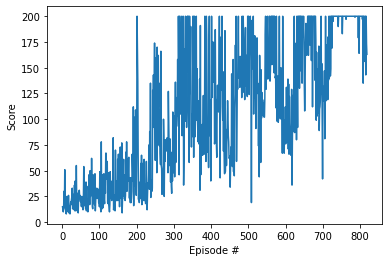

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores))+1, scores)
plt.xlabel('Episode #')
plt.ylabel('Score')
plt.show()

## 4. Watch the trained agent perform the task

To display the how the trained agent performs the tast on `Google Colab` we have to record a video as done here: https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t#scrollTo=nQEtc28G4niA

In [6]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
env = wrap_env(gym.make('CartPole-v0'))

state = env.reset()
for t in range(9000):

    env.render()
    action, _ = policy.act(state)
    state, reward, done, _ = env.step(action)
    # fig, ax = plt.subplots(figsize=(20, 10))
    # ax.axis('off')
    # img = ax.imshow(env.render(mode='rgb_array'))
    # #img.set_data(env.render(mode='rgb_array')) 
    # display.display(plt.gcf())
    if done:
        break

env.close()
show_video()

## 5. Comments

### 5.1 Implementation

The reason why the ```backward()``` operation in ```PyTorch``` works on categorical probability distributions is explained here: https://pytorch.org/docs/stable/distributions.html

### 5.2 Performance

While REINFORCE can solve the control task of balancing the pole attached to the cartwheel, from the graph of the training scores we can see the algorithm is not very stable. In fact if the random seed for the CartPole-v0 environment or the ``PyTorch`` library is changed (e.g. try ``env.seed(22)`` with ``torch.manual_seed(0)``) the algorithm will not converge i.e. a score of 195 over 100 episodes will not be achieved even if we increase the size of the first hidden layer in the NN to an arbitrary large number e.g. 1024 or if use multiple hidden layers. Tuning other hyperparameters e.g. the learning rate of the Adam algorithm, using different activation functions e.g. ``tanh`` etc. will not help either. 

[Proximal Policy Optimization](https://arxiv.org/pdf/1707.06347.pdf) overcomes the limitations of REINFORCE. 